# 1. Data Load

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 
from pickle import dump

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
path = "./Dataset/"

data = pd.read_csv(path+"train.csv")

# original data -> data
data

,index,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,...,1.0,20,2.0,12.0,4.0,2.0,1.0,4.0,2.0,1
1,1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,...,1.0,49,1.0,2.0,1.0,1.0,2.0,4.0,2.0,1
2,2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,...,2.0,43,1.0,2.0,2.0,2.0,3.0,4.0,2.0,1
3,3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,...,1.0,17,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1
4,4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,...,2.0,18,2.0,12.0,1.0,2.0,1.0,1.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2.0,5.0,4.0,3.0,3.0,4.0,4.0,4.0,3.0,...,1.0,17,1.0,1.0,3.0,2.0,1.0,3.0,2.0,0
14996,14996,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,...,2.0,45,1.0,3.0,1.0,1.0,2.0,3.0,2.0,1
14997,14997,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,...,1.0,20,1.0,1.0,2.0,1.0,1.0,3.0,1.0,1
14998,14998,5.0,5.0,4.0,5.0,5.0,5.0,5.0,1.0,5.0,...,1.0,29,1.0,12.0,4.0,2.0,2.0,2.0,1.0,0


# 2. EDA 

15,000 rows × 70 columns

- feature (1)
    - index 
- Categorical variable (63)
    - country : 137 values, not valanced 
    - education : 4 values 
    - urban : 4 values, but start with 0 
    - gender : 3 
    - engnat : 2 
    - hand : 3 
    - religion : 12 
    - orientation : 5
    - voted : 2
    - married : 3
    - ASD : 2 
    - Q(26) : 5 values
        - 1=Disagree, 2=Slightly disagree, 3=Neutral, 4=Slightly agree, 5=Agree
    - TIPI(10) : 5 values 
        - items were rated "I see myself as:" _____ such that Extraverted, enthusiastic...
    - VCL(16) : 2 values (0 or 1) 
- Numerical variable (5)
    - introelapse : 1315 values 
    - testelapse : 684 values 
    - surveyelapse : 712 values
    - age : 76 values, but maybe outlier...
    - familysize : 20 values, but maybe outlier... 
- Y variable (1)
    - nerdiness 
        - binary classification 
        - 1:8303, 0:6697

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         15000 non-null  int64  
 1   Q1            14959 non-null  float64
 2   Q2            14931 non-null  float64
 3   Q3            14950 non-null  float64
 4   Q4            14929 non-null  float64
 5   Q5            14962 non-null  float64
 6   Q6            14952 non-null  float64
 7   Q7            14924 non-null  float64
 8   Q8            14952 non-null  float64
 9   Q9            14944 non-null  float64
 10  Q10           14928 non-null  float64
 11  Q11           14941 non-null  float64
 12  Q12           14933 non-null  float64
 13  Q13           14960 non-null  float64
 14  Q14           14964 non-null  float64
 15  Q15           14955 non-null  float64
 16  Q16           14967 non-null  float64
 17  Q17           14963 non-null  float64
 18  Q18           14937 non-nu

<AxesSubplot:>

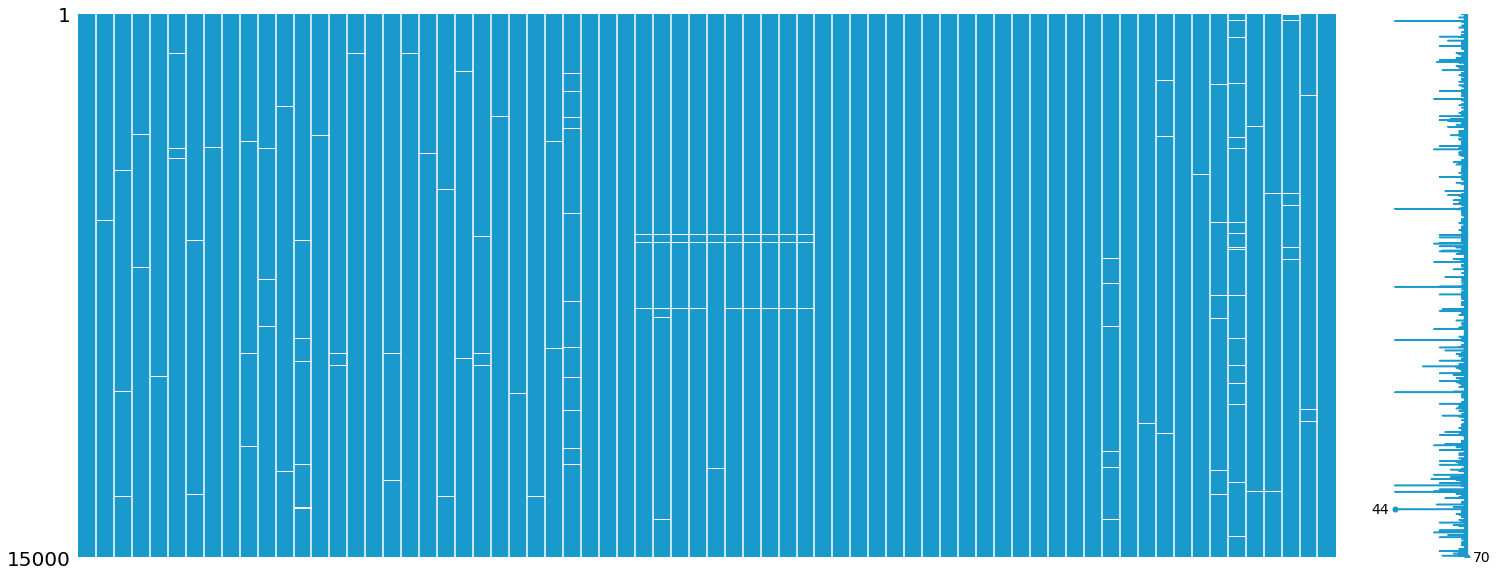

In [4]:
# missing value check
msno.matrix(data.iloc[:, :], color=(0.1, 0.6, 0.8))

# 3.1. Preprocessing - TrainData
data -> processed_data (**15,000 x 70 -> 15,000 x 50**)

Basic 
- **Drop unnecessary features** 
    - index, country(...)
- **Handling missing values (...)**
    - **fillna 0**
        - education, gender, hand, religion, orientation, voted, married, ASD
        - 무응답은 0으로 채우기 (urban은 이미 0부터 시작) 
    - **imputation : simple method**
        
Question (Q, TIPI, VCL)
- TIPI scoring to 'O', 'C', 'E', 'A', 'N' 
- VCL scoring (he words at **VCL6, VCL9, and VCL12** are not real words and can be used as a validity check)

    
Numerical
- **Log Transformation**
    - 3 elapse cols (intro, test, survey)
- **Ranging**
    - 'age' to 10 category (0~10/10~20..90~100)
- **Handling outlier**
    - 'familysize' to make np.Nan and imputate


In [35]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# Feature drop 
# 'index', 'country'
processed_data = data.drop(['index','country'], axis=1).copy()

In [36]:
# Handling missing values with simple imputator
# 'education', 'gender', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'
from sklearn.impute import SimpleImputer

fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD']
transformer = SimpleImputer()
processed_data[fill_cols] = transformer.fit_transform(processed_data[fill_cols])
processed_data[fill_cols].describe()

,education,gender,engnat,hand,religion,orientation,voted,married,ASD
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,2.314232,1.703024,1.346018,1.185113,4.098340,1.847956,1.633121,1.179917,1.938703
std,0.916050,0.552935,0.474969,0.481237,3.397606,1.206812,0.480602,0.464709,0.239170
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000
50%,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000
75%,3.000000,2.000000,2.000000,1.000000,6.000000,2.000000,2.000000,1.000000,2.000000
max,4.000000,3.000000,2.000000,3.000000,12.000000,5.000000,2.000000,3.000000,2.000000


In [6]:
# country
country_nerdL = ['SWE', 'DEU', 'USA']
country_nerdM = ['NLD', 'ITA', 'GBR', 'AUS', 'POL', 'CAN', 'FRA', 'IDN', 'BRA', 'NOR', 'FIN']
country_nerdS = ['PHL', 'NZL', 'MYS', 'MEX', 'IND', 'SGP']

# Lable Encoding : 'country' 
from sklearn.preprocessing import LabelEncoder

# missing values as 0 
processed_data['country'] = processed_data['country'].fillna(0)
# labeling top countries as 2, 3, 4
processed_data['country'] = processed_data['country'].apply(lambda x : 2 if x in country_nerdL else x)
processed_data['country'] = processed_data['country'].apply(lambda x : 3 if x in country_nerdM else x)
processed_data['country'] = processed_data['country'].apply(lambda x : 4 if x in country_nerdS else x)
# labeling other countries as 1
processed_data['country'] = processed_data['country'].apply(lambda x : 1 if x not in [0, 2, 3, 4] else x)

# check
print(processed_data['country'].unique())

[2 3 1 4 0]


In [17]:
# # Lable Encoding : 'country' 
# from sklearn.preprocessing import LabelEncoder

# # missing values as 0 
# processed_data['country'] = processed_data['country'].fillna(0)

# # labeling the other countries as 1 
# df_country = pd.DataFrame(data['country'].value_counts())
# others = df_country[df_country['country']==1].index.values.tolist()
# processed_data['country'] = processed_data['country'].apply(lambda x : 1 if x in others else x)

# le_cnt = LabelEncoder()
# processed_data['country'] = le_cnt.fit_transform(list(processed_data['country']))   
# print(le_cnt.classes_)

# # save encoder
# dump(le_cnt, open('labelencoder.pkl', 'wb'))

['0' '1' 'ALB' 'ARE' 'ARG' 'ARM' 'AUS' 'AUT' 'AZE' 'BEL' 'BGD' 'BGR' 'BHR'
 'BHS' 'BIH' 'BRA' 'BRN' 'BWA' 'CAN' 'CHE' 'CHL' 'CHN' 'COL' 'CRI' 'CUW'
 'CYP' 'CZE' 'DEU' 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ESP' 'EST' 'FIN' 'FJI'
 'FRA' 'FRO' 'FSM' 'GBR' 'GEO' 'GHA' 'GRC' 'GUM' 'HKG' 'HND' 'HRV' 'HUN'
 'IDN' 'IND' 'IRL' 'IRN' 'ISL' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN' 'KEN' 'KOR'
 'KWT' 'LBN' 'LTU' 'LUX' 'LVA' 'MAR' 'MEX' 'MKD' 'MLT' 'MOZ' 'MYS' 'NAM'
 'NGA' 'NLD' 'NOR' 'NPL' 'NZL' 'OMN' 'PAK' 'PAN' 'PER' 'PHL' 'POL' 'PRI'
 'PRT' 'PRY' 'QAT' 'ROU' 'RUS' 'SAU' 'SDN' 'SGP' 'SLV' 'SRB' 'SSD' 'SVK'
 'SVN' 'SWE' 'THA' 'TTO' 'TUN' 'TUR' 'TWN' 'UKR' 'URY' 'USA' 'VEN' 'VNM'
 'ZAF' 'ZMB']


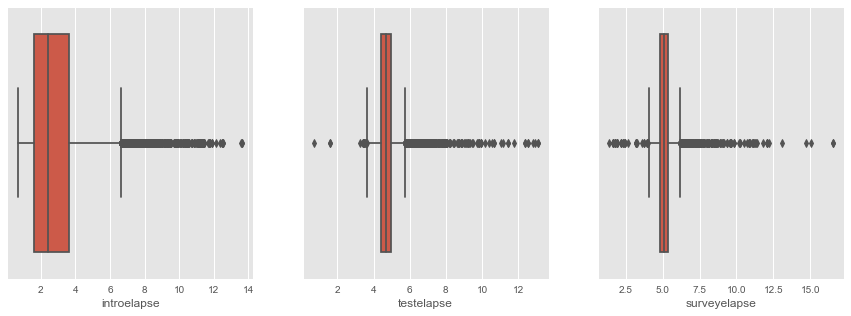

In [37]:
# Log Transformation
# 'introelapse','testelapse','surveyelapse'
right_skewed_cols = ['introelapse','testelapse','surveyelapse']
for c in right_skewed_cols : 
    processed_data[c] = np.log1p(processed_data[c])

# for checking 
plt.style.use("ggplot") 
plt.figure(figsize=(15,5))
    
for i in range(len(right_skewed_cols)):
    plt.subplot(1,3,i+1)
    sns.boxplot(x=right_skewed_cols[i], data=processed_data)

In [38]:
# Ranging and Ordinary Encoding 
# 'age'
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

bins= [10,20,30,40,50,60,70,80,90,100,40000]
labels = [10,20,30,40,50,60,70,80,90,100]
processed_data['age'] = pd.cut(processed_data['age'], bins=bins, labels=labels, right=False)

oe = OrdinalEncoder()
processed_data['age'] = oe.fit_transform(processed_data['age'].values.reshape(-1,1))
processed_data['age'].value_counts()

0.0    6824
1.0    5161
2.0    1493
3.0     822
4.0     459
5.0     202
6.0      28
9.0       7
7.0       3
8.0       1
Name: age, dtype: int64

count    15000.000000
mean         2.298851
std          0.836876
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: familysize, dtype: float64


<AxesSubplot:xlabel='familysize'>

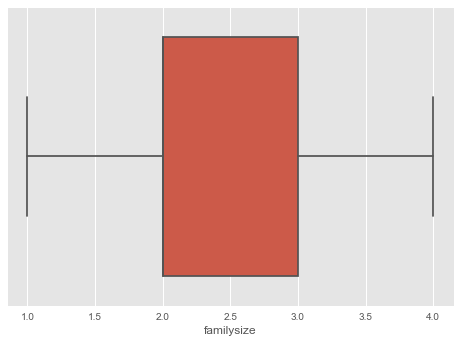

In [39]:
# Handling outlier
# 'familysize'
Q1 = processed_data['familysize'].quantile(0.25)
Q2 = processed_data['familysize'].quantile(0.5)
Q3 = processed_data['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
processed_data['familysize'] = processed_data['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
transformer =  IterativeImputer()
processed_data[['familysize', 'nerdiness']] = transformer.fit_transform(processed_data[['familysize', 'nerdiness']])
print(processed_data['familysize'].describe())
sns.boxplot(x='familysize', data=processed_data)

<AxesSubplot:>

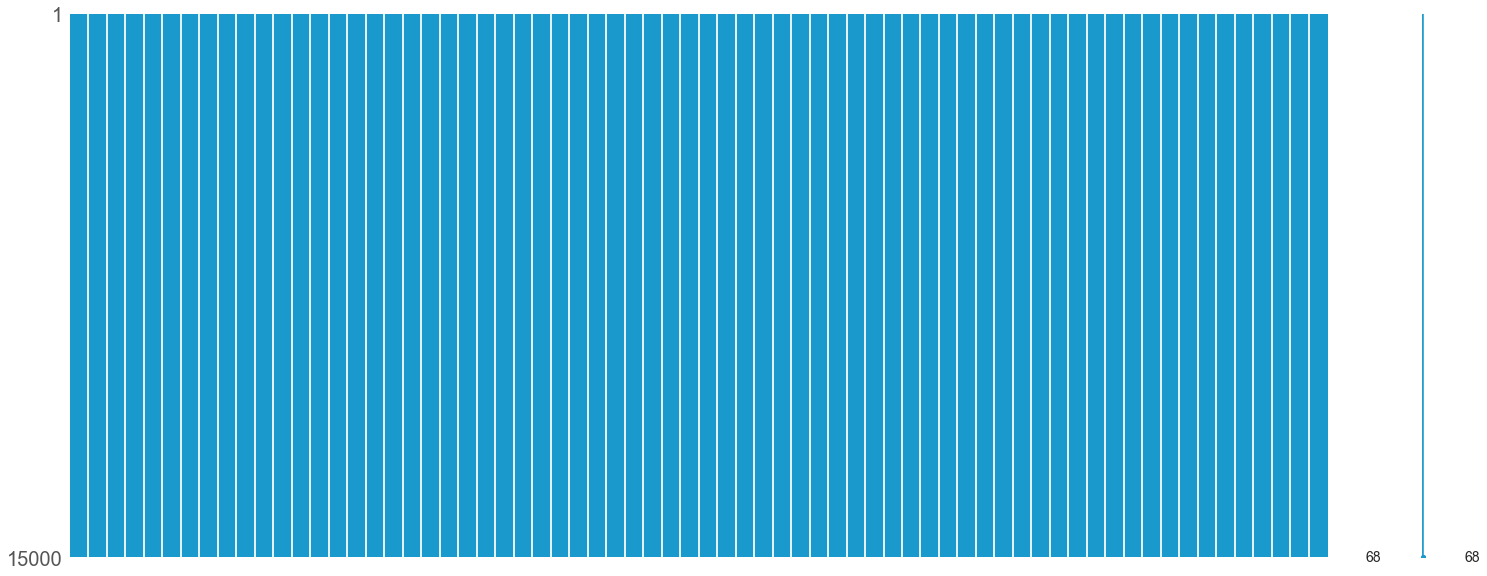

In [40]:
# finish handling missing values! 
npas_cols = ['Q{}'.format(i) for i in range(1,27)]
tipi_cols = ['TIPI{}'.format(i) for i in range(1,11)]
vcl_cols = ['VCL{}'.format(i) for i in range(1,17)]
mach_cols = ['Q{}'.format(i) for i in range(1,21)]
nomach_cols = ['Q{}'.format(i) for i in range(21,27)]
q_cols = [npas_cols, tipi_cols, vcl_cols]

for col in q_cols : 
    transformer = SimpleImputer()
    processed_data[col] = transformer.fit_transform(processed_data[col])
    
msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

In [41]:
def score_mach(data) :
    rev_cols = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17', 'Q14', 'Q18']
    for flip in rev_cols: 
        data[flip] = 6 - data[flip]
    data['Mach'] = data[mach_cols].mean(axis=1)
    #data.drop(mach_cols, axis=1, inplace = True)
    return data 

processed_data = score_mach(processed_data)
processed_data['Mach']

0        3.05
1        3.10
2        3.00
3        2.95
4        2.95
         ... 
14995    3.15
14996    2.80
14997    3.00
14998    2.65
14999    2.95
Name: Mach, Length: 15000, dtype: float64

In [42]:
def score_tipi(data) :
    data['E'] = (data['TIPI1'] + (8-data['TIPI6'])) / 2
    data['A'] = (data['TIPI7'] + (8-data['TIPI2'])) / 2
    data['C'] = (data['TIPI3'] + (8-data['TIPI8'])) / 2
    data['N'] = (data['TIPI9'] + (8-data['TIPI4'])) / 2
    data['O'] = (data['TIPI5'] + (8-data['TIPI10'])) / 2
    data.drop(['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10'], axis=1, inplace = True)
    return data 

processed_data = score_tipi(processed_data)
processed_data[['E', 'A', 'C', 'N', 'O']]

,E,A,C,N,O
0,3.5,5.0,5.0,6.0,4.0
1,5.0,5.5,5.0,2.5,4.5
2,2.0,4.5,3.5,6.0,5.5
3,4.0,4.5,3.5,3.5,5.0
4,3.5,4.0,4.0,3.5,5.0
...,...,...,...,...,...
14995,2.5,4.5,4.5,4.0,4.0
14996,4.0,5.0,5.5,2.5,5.0
14997,2.0,4.0,3.5,2.0,4.0
14998,2.0,6.0,3.5,2.5,5.5


In [43]:
def score_vcl(data) :
    data['VCL_score'] = (data['VCL1'] + data['VCL2'] + data['VCL3'] + data['VCL4'] + data['VCL5'] + data['VCL7'] + data['VCL8']
                        + data['VCL10'] + data['VCL11'] + data['VCL13'] + data['VCL14'] + data['VCL15'] + data['VCL16'])
    data['VCL_faker'] = (data['VCL6'] + data['VCL9'] + data['VCL12'])
    data.drop(['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 
               'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16',], axis=1, inplace = True)
    return data 

processed_data = score_vcl(processed_data)
processed_data[['VCL_score', 'VCL_faker']]

,VCL_score,VCL_faker
0,8.0,0.0
1,11.0,0.0
2,11.0,0.0
3,9.0,0.0
4,8.0,0.0
...,...,...
14995,10.0,1.0
14996,8.0,0.0
14997,9.0,0.0
14998,11.0,1.0


<AxesSubplot:>

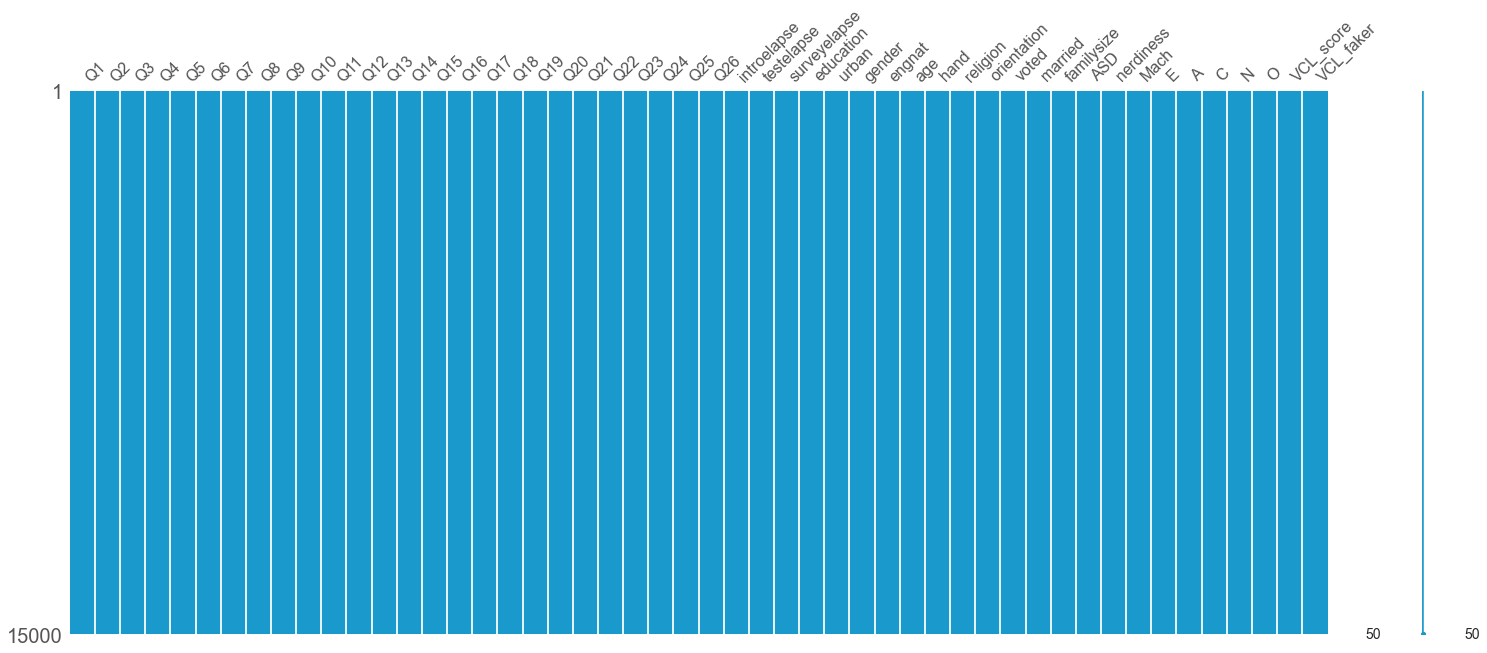

In [44]:
msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

# 3.2. Preprocessing - TestData
test -> test (**15,000 x 70 -> 15,000 x 50**)

In [45]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
test = pd.read_csv(path+"test.csv")

# Feature drop : 'index'
test = test.drop(['index', 'country'], axis=1).copy()

# Handling missing values : 'education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'
from sklearn.impute import SimpleImputer
fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD']
transformer = SimpleImputer()
test[fill_cols] = transformer.fit_transform(test[fill_cols])
test[fill_cols].describe()

# labeling the other countries as 1 
#df_country = pd.DataFrame(test['country'].value_counts())
#others = df_country[df_country['country']==1].index.values.tolist()
#test['country'] = test['country'].apply(lambda x : 1 if x in others else x)
#test['country'] = le_cnt.fit_transform(list(test['country']))   

# Log Transformation : 'introelapse','testelapse','surveyelapse'
right_skewed_cols = ['introelapse','testelapse','surveyelapse']
for c in right_skewed_cols : 
    test[c] = np.log1p(test[c])

# Ranging and Ordinary encoding: 'age'
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
bins= [10,20,30,40,50,60,70,80,90,100,40000]
labels = [10,20,30,40,50,60,70,80,90,100]
test['age'] = pd.cut(test['age'], bins=bins, labels=labels, right=False)
oe = OrdinalEncoder()
test['age'] = oe.fit_transform(test['age'].values.reshape(-1,1))

# Handling outlier and iterative imputation : 'familysize'
Q1 = test['familysize'].quantile(0.25)
Q2 = test['familysize'].quantile(0.5)
Q3 = test['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
test['familysize'] = test['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
transformer =  IterativeImputer()
test[['familysize']] = transformer.fit_transform(test[['familysize']])
test['familysize'] = test['familysize'].astype(int)
print(test['familysize'].describe())

count    35452.000000
mean         2.268814
std          0.840906
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: familysize, dtype: float64


<AxesSubplot:>

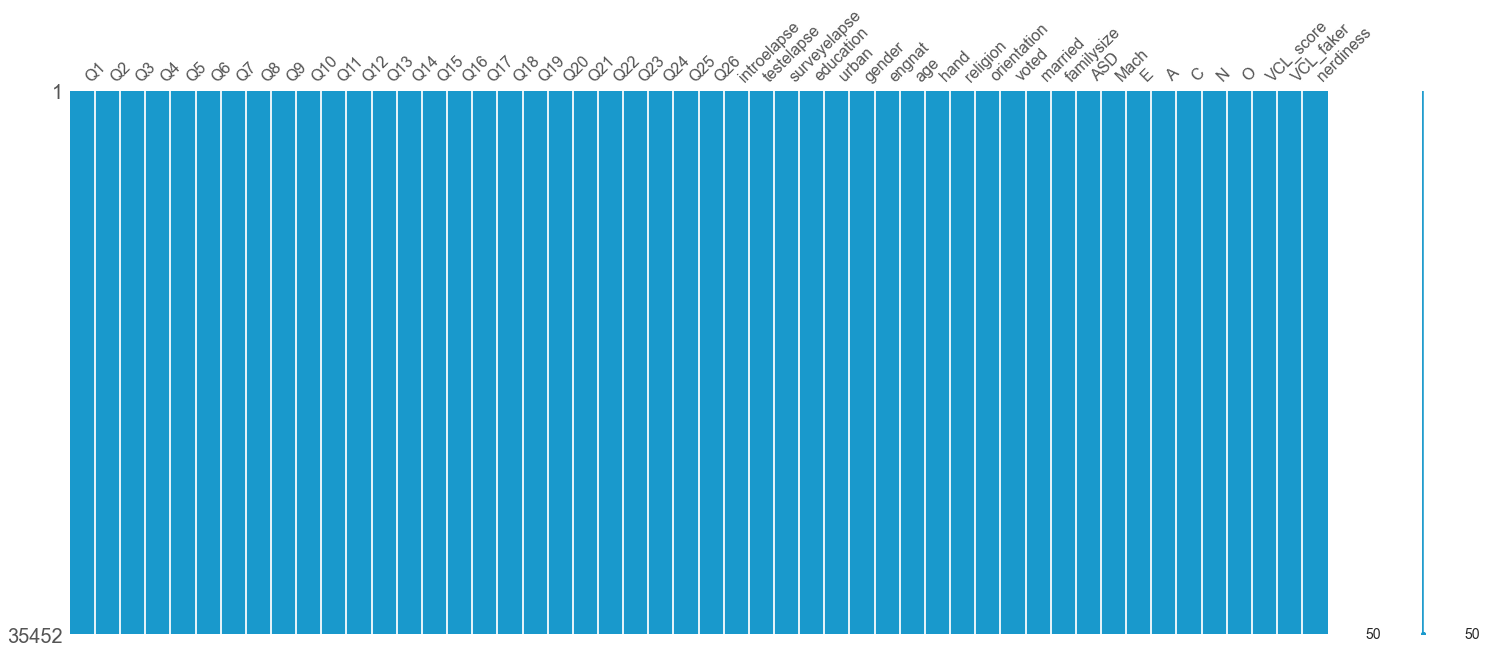

In [46]:
def score_mach(data) :
    rev_cols = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17', 'Q14', 'Q18']
    for flip in rev_cols: 
        data[flip] = 6 - data[flip]
    data['Mach'] = data[mach_cols].mean(axis=1)
    #data.drop(mach_cols, axis=1, inplace = True)
    return data 

def score_tipi(data) :
    data['E'] = (data['TIPI1'] + (8-data['TIPI6'])) / 2
    data['A'] = (data['TIPI7'] + (8-data['TIPI2'])) / 2
    data['C'] = (data['TIPI3'] + (8-data['TIPI8'])) / 2
    data['N'] = (data['TIPI9'] + (8-data['TIPI4'])) / 2
    data['O'] = (data['TIPI5'] + (8-data['TIPI10'])) / 2
    data.drop(['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10'], axis=1, inplace = True)
    return data 

def score_vcl(data) :
    data['VCL_score'] = (data['VCL1'] + data['VCL2'] + data['VCL3'] + data['VCL4'] + data['VCL5'] + data['VCL7'] + data['VCL8']
                        + data['VCL10'] + data['VCL11'] + data['VCL13'] + data['VCL14'] + data['VCL15'] + data['VCL16'])
    data['VCL_faker'] = (data['VCL6'] + data['VCL9'] + data['VCL12'])
    data.drop(['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 
               'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16',], axis=1, inplace = True)
    return data 

from sklearn.impute import SimpleImputer
npas_cols = ['Q{}'.format(i) for i in range(1,27)]
tipi_cols = ['TIPI{}'.format(i) for i in range(1,11)]
vcl_cols = ['VCL{}'.format(i) for i in range(1,17)]
mach_cols = ['Q{}'.format(i) for i in range(1,21)]
q_cols = [npas_cols, tipi_cols, vcl_cols]
for col in q_cols : 
    transformer = SimpleImputer()
    test[col] = transformer.fit_transform(test[col])

test = score_mach(test)
test = score_tipi(test)
test = score_vcl(test)

# pycaret에 넣기 위해서 일부러 넣어주는 것 
test['nerdiness'] = 0.00

msno.matrix(test.iloc[:, :], color=(0.1, 0.6, 0.8))

# 4. Data Split 
split data as train/valid

Test 하려면 아래의 cell 실행

In [45]:
# 전처리된 data와 따로 관리 -> preprocessed data = procssed_data, input data = input_data 
input_data = processed_data.copy()
input_data_y = input_data['nerdiness'].copy()
input_data_X = input_data.drop(['nerdiness'], axis=1)

# train/ test data 로 split 
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 7,
    shuffle=True
)

train_data = pd.concat([train_X, train_y], axis=1).reset_index(drop=True)
test_data = pd.concat([test_X, test_y], axis=1).reset_index(drop=True)
test_data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,ASD,Mach,E,A,C,N,O,VCL_score,VCL_faker,nerdiness
0,5.0,1.0,1.0,1.0,5.0,5.0,1.0,3.0,1.0,1.0,...,2.0,2.45,4.0,4.5,5.0,5.0,6.0,13.0,0.0,1.0
1,4.0,4.0,1.0,2.0,2.0,4.0,1.0,4.0,1.0,1.0,...,2.0,2.35,4.5,5.0,4.5,6.0,5.5,10.0,1.0,0.0
2,4.0,5.0,1.0,5.0,3.0,5.0,2.0,5.0,3.0,1.0,...,2.0,3.60,2.5,4.0,5.0,2.0,4.0,10.0,0.0,1.0
3,3.0,5.0,2.0,5.0,5.0,4.0,1.0,4.0,2.0,1.0,...,2.0,3.10,2.0,6.0,4.5,4.5,5.0,11.0,0.0,0.0
4,4.0,4.0,2.0,1.0,5.0,4.0,1.0,3.0,1.0,1.0,...,2.0,2.80,4.5,3.5,4.0,5.0,6.0,10.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,4.0,4.0,1.0,4.0,5.0,4.0,1.0,5.0,3.0,2.0,...,2.0,2.95,2.0,4.5,5.5,4.5,4.0,5.0,0.0,1.0
2996,5.0,4.0,2.0,2.0,4.0,2.0,3.0,4.0,5.0,5.0,...,2.0,3.05,3.5,3.0,3.0,2.0,5.5,8.0,0.0,1.0
2997,4.0,5.0,1.0,2.0,4.0,4.0,1.0,5.0,2.0,1.0,...,2.0,3.05,3.5,5.0,4.5,3.0,5.5,10.0,0.0,1.0
2998,4.0,4.0,1.0,2.0,5.0,4.0,2.0,4.0,2.0,1.0,...,2.0,2.90,4.0,3.5,3.5,3.0,4.5,11.0,0.0,0.0


Predict 하려면 아래의 cell 실행

In [15]:
train_data = processed_data.copy()
test_data = test.copy()
test_data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,ASD,Mach,E,A,C,N,O,VCL_score,VCL_faker,nerdiness
0,4.0,4.0,3.0,1.0,5.0,5.0,3.0,5.0,2.0,1.0,...,2.0,3.30,3.0,3.5,4.0,3.5,5.0,12.0,3.0,0.0
1,4.0,5.0,2.0,2.0,5.0,4.0,1.0,5.0,1.0,2.0,...,2.0,3.10,2.0,3.5,4.0,3.0,5.5,10.0,0.0,0.0
2,5.0,5.0,1.0,1.0,4.0,5.0,1.0,5.0,1.0,2.0,...,2.0,3.10,3.5,5.0,4.5,3.5,5.5,9.0,0.0,0.0
3,5.0,4.0,3.0,2.0,5.0,4.0,1.0,4.0,2.0,1.0,...,2.0,3.10,2.5,4.0,3.5,4.0,5.5,12.0,2.0,0.0
4,5.0,5.0,1.0,1.0,5.0,3.0,1.0,5.0,1.0,1.0,...,2.0,2.95,3.5,4.0,3.5,3.0,4.5,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35447,4.0,5.0,1.0,3.0,3.0,4.0,1.0,5.0,2.0,3.0,...,2.0,2.95,4.0,4.0,5.0,3.0,6.0,3.0,0.0,0.0
35448,5.0,5.0,1.0,1.0,5.0,4.0,1.0,3.0,1.0,3.0,...,2.0,2.80,3.0,5.0,5.0,2.0,4.5,9.0,0.0,0.0
35449,5.0,5.0,1.0,1.0,5.0,5.0,1.0,5.0,1.0,1.0,...,2.0,3.10,3.0,3.0,3.5,3.5,5.5,11.0,0.0,0.0
35450,5.0,5.0,2.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.60,3.0,4.0,6.0,6.0,6.0,10.0,3.0,0.0


# 5. AutoML 

using pycaret, autoML Library

In [16]:
from pycaret.classification import *
from time import time

In [62]:
# Setup Environment  
cat_cols = ['urban', 'education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'] + npas_cols
num_cols = ['introelapse', 'testelapse', 'surveyelapse', 'familysize', 'Mach', 'E', 'A', 'C', 'N', 'O', 'VCL_score', 'VCL_faker'] 
ord_cols = ['age'] 
ord_dict = {} 
for col in ord_cols :
    unique_list = train_data[col].unique()
    unique_list = sorted(unique_list[~pd.isnull(unique_list)])
    ord_dict[col] = unique_list

clf = setup(data = train_data, 
            test_data = test_data,
            target = 'nerdiness',
            categorical_features = cat_cols,
            numeric_features = num_cols,
            ordinal_features = ord_dict,
            high_cardinality_features = ['religion'],
            high_cardinality_method = 'frequency',
            handle_unknown_categorical = True,
            data_split_stratify = True,
            normalize = True,
            normalize_method = 'zscore', 
            #feature_selection = True,
            imputation_type='simple', # 없어도 됨 이미 전처리 다 해줘서 
            fold_shuffle=True,
            use_gpu = True,
            silent = True,
            session_id = 6315)

,Description,Value
0,session_id,6315
1,Target,nerdiness
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(12000, 50)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,36
8,Ordinal Features,True
9,High Cardinality Features,True


## Comparing

In [99]:
# et, rf, cat, lgbm, gbc
top5 = compare_models(sort='AUC', n_select=5, fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7678,0.8535,0.8264,0.7699,0.7971,0.5266,0.5284,1.1240
et,Extra Trees Classifier,0.7612,0.8529,0.8131,0.7679,0.7899,0.5138,0.5149,1.4060
catboost,CatBoost Classifier,0.7699,0.8479,0.8287,0.7715,0.7990,0.5308,0.5328,4.8340
xgboost,Extreme Gradient Boosting,0.7709,0.8450,0.8182,0.7783,0.7977,0.5340,0.5351,1.0640
lightgbm,Light Gradient Boosting Machine,0.7638,0.8420,0.8246,0.7657,0.7940,0.5182,0.5203,0.1760
gbc,Gradient Boosting Classifier,0.7482,0.8260,0.8104,0.7525,0.7803,0.4862,0.4881,4.5680
ada,Ada Boost Classifier,0.7356,0.8085,0.7959,0.7433,0.7686,0.4610,0.4626,1.5340
lr,Logistic Regression,0.7203,0.7918,0.7816,0.7306,0.7551,0.4300,0.4314,1.0080
lda,Linear Discriminant Analysis,0.7193,0.7910,0.7837,0.7285,0.7550,0.4275,0.4292,0.3160
nb,Naive Bayes,0.6944,0.7520,0.7686,0.7047,0.7352,0.3756,0.3776,0.0860


## Training top 5 models

In [63]:
total_models = []

In [64]:
cell_start_time = time()
model_et = create_model('et', fold = 10)
total_models.append(model_et)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7667,0.8594,0.8175,0.7732,0.7947,0.5249,0.5260
1,0.7708,0.8635,0.8220,0.7764,0.7985,0.5333,0.5345
2,0.7492,0.8431,0.7994,0.7593,0.7788,0.4896,0.4904
3,0.7692,0.8615,0.8235,0.7734,0.7977,0.5296,0.5310
4,0.7783,0.8661,0.8520,0.7705,0.8092,0.5464,0.5503
5,0.7783,0.8710,0.8172,0.7886,0.8027,0.5500,0.5505
6,0.7858,0.8673,0.8293,0.7922,0.8103,0.5647,0.5655
7,0.7617,0.8542,0.8051,0.7725,0.7885,0.5158,0.5164
8,0.7842,0.8729,0.8429,0.7826,0.8116,0.5598,0.5619


CELL RUN TIME :  17.616605520248413


In [65]:
cell_start_time = time()
model_rf = create_model('rf', fold = 10)
total_models.append(model_rf)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7825,0.8625,0.8220,0.7922,0.8068,0.5582,0.5587
1,0.7875,0.8662,0.8356,0.7914,0.8129,0.5674,0.5686
2,0.7392,0.8426,0.8039,0.7444,0.7730,0.4675,0.4694
3,0.7758,0.8631,0.8446,0.7713,0.8063,0.5416,0.5447
4,0.7825,0.8708,0.8535,0.7750,0.8124,0.5551,0.5588
5,0.7750,0.8623,0.8218,0.7816,0.8012,0.5424,0.5433
6,0.7917,0.8613,0.8369,0.7960,0.8159,0.5763,0.5773
7,0.7642,0.8572,0.8051,0.7758,0.7902,0.5212,0.5216
8,0.7717,0.8677,0.8323,0.7717,0.8009,0.5342,0.5363


CELL RUN TIME :  12.995299577713013


In [66]:
cell_start_time = time()
model_cat = create_model('catboost', fold = 10)
total_models.append(model_cat)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7825,0.8575,0.8326,0.7863,0.8088,0.5571,0.5583
1,0.7708,0.8533,0.8265,0.7740,0.7994,0.5328,0.5344
2,0.7567,0.8379,0.8084,0.7646,0.7859,0.5046,0.5056
3,0.7717,0.8484,0.8446,0.7661,0.8034,0.5326,0.5362
4,0.7650,0.8513,0.8369,0.7610,0.7971,0.5194,0.5227
5,0.7908,0.8590,0.8429,0.7915,0.8164,0.5740,0.5755
6,0.7783,0.8480,0.8338,0.7797,0.8058,0.5483,0.5499
7,0.7700,0.8467,0.8248,0.7734,0.7982,0.5314,0.5329
8,0.7883,0.8581,0.8444,0.7873,0.8149,0.5685,0.5704


CELL RUN TIME :  64.65575933456421


In [67]:
cell_start_time = time()
model_lgbm = create_model('lightgbm', fold = 10)
total_models.append(model_lgbm)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7700,0.8439,0.8100,0.7817,0.7956,0.5329,0.5333
1,0.7792,0.8520,0.8386,0.7787,0.8076,0.5493,0.5514
2,0.7467,0.8264,0.7979,0.7568,0.7768,0.4844,0.4853
3,0.7625,0.8373,0.8311,0.7610,0.7945,0.5145,0.5173
4,0.7717,0.8491,0.8520,0.7622,0.8046,0.5321,0.5368
5,0.7725,0.8491,0.8278,0.7751,0.8006,0.5365,0.5380
6,0.7725,0.8369,0.8112,0.7839,0.7973,0.5382,0.5386
7,0.7675,0.8444,0.8187,0.7732,0.7953,0.5268,0.5279
8,0.7725,0.8542,0.8187,0.7799,0.7988,0.5374,0.5383


CELL RUN TIME :  2.1937761306762695


In [68]:
cell_start_time = time()
model_xgb = create_model('xgboost', fold = 10)
total_models.append(model_xgb)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7833,0.8597,0.8145,0.7976,0.8060,0.5607,0.5609
1,0.7850,0.8593,0.8265,0.7931,0.8095,0.5630,0.5637
2,0.7467,0.8258,0.7753,0.7683,0.7718,0.4871,0.4872
3,0.7733,0.8408,0.8296,0.7757,0.8017,0.5379,0.5395
4,0.7775,0.8455,0.8369,0.7770,0.8058,0.5462,0.5482
5,0.7725,0.8546,0.8248,0.7767,0.8000,0.5368,0.5381
6,0.7675,0.8446,0.7976,0.7845,0.7910,0.5291,0.5292
7,0.7717,0.8461,0.8127,0.7820,0.7970,0.5363,0.5368
8,0.7742,0.8553,0.8218,0.7805,0.8006,0.5407,0.5416


CELL RUN TIME :  11.21057391166687


## Tuninig Models 

In [ ]:
model_et = tune_model(model_et, search_library = 'scikit-optimize', optimize = 'AUC', choose_better = True)

In [ ]:
model_rf = tune_model(model_rf, search_library = 'scikit-optimize', optimize = 'AUC', choose_better = True)

In [69]:
model_cat = tune_model(model_cat, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7975,0.8782,0.8371,0.8043,0.8204,0.5885,0.5891
1,0.7975,0.8825,0.8507,0.7966,0.8228,0.5872,0.5889
2,0.7625,0.8481,0.8145,0.7692,0.7912,0.5164,0.5175
3,0.7908,0.8679,0.8446,0.7910,0.8169,0.5736,0.5753
4,0.7775,0.8642,0.8338,0.7786,0.8053,0.5465,0.5482
5,0.7833,0.8755,0.8399,0.7831,0.8105,0.5583,0.5602
6,0.7775,0.8573,0.8338,0.7786,0.8053,0.5465,0.5482
7,0.7725,0.8648,0.8172,0.7807,0.7985,0.5376,0.5383
8,0.7883,0.8725,0.8293,0.7957,0.8121,0.5700,0.5706


In [70]:
model_lgbm = tune_model(model_lgbm, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7517,0.8367,0.7768,0.7744,0.7756,0.4976,0.4976
1,0.7667,0.8394,0.8069,0.7787,0.7926,0.5261,0.5266
2,0.7542,0.8263,0.8009,0.7651,0.7826,0.5001,0.5008
3,0.7625,0.8344,0.8054,0.7739,0.7894,0.5174,0.5179
4,0.7600,0.8238,0.8082,0.7687,0.7879,0.5119,0.5128
5,0.7683,0.8405,0.8036,0.7824,0.7928,0.5302,0.5304
6,0.7575,0.8298,0.7961,0.7716,0.7836,0.5080,0.5083
7,0.7550,0.8280,0.8082,0.7621,0.7845,0.5012,0.5024
8,0.7625,0.8366,0.8066,0.7728,0.7894,0.5174,0.5181


In [71]:
model_xgb = tune_model(model_xgb, search_library = 'optuna', optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7383,0.8624,0.9472,0.6924,0.8000,0.4470,0.4950
1,0.7358,0.8667,0.9517,0.6889,0.7992,0.4407,0.4925
2,0.7217,0.8353,0.9336,0.6810,0.7875,0.4115,0.4566
3,0.7408,0.8539,0.9532,0.6930,0.8025,0.4517,0.5028
4,0.7283,0.8606,0.9562,0.6806,0.7952,0.4239,0.4813
5,0.7392,0.8695,0.9532,0.6911,0.8013,0.4486,0.5002
6,0.7308,0.8516,0.9517,0.6840,0.7960,0.4302,0.4836
7,0.7150,0.8486,0.9502,0.6706,0.7862,0.3948,0.4524
8,0.7342,0.8614,0.9532,0.6866,0.7982,0.4374,0.4907


In [72]:
tuned_models = [model_et, model_rf, model_cat, model_lgbm, model_xgb]

## Blending Models

In [73]:
blender_top5 = blend_models(estimator_list=tuned_models)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7892,0.8832,0.8869,0.7676,0.8230,0.5657,0.5748
1,0.7992,0.8886,0.9020,0.7726,0.8323,0.5857,0.5967
2,0.7658,0.8598,0.8733,0.7461,0.8047,0.5168,0.5268
3,0.7925,0.8775,0.9035,0.7640,0.8279,0.5712,0.5840
4,0.7850,0.8841,0.9124,0.7512,0.8240,0.5543,0.5718
5,0.7975,0.8864,0.9154,0.7642,0.8330,0.5811,0.5965
6,0.7792,0.8728,0.8958,0.7516,0.8174,0.5435,0.5570
7,0.7850,0.8775,0.8867,0.7623,0.8198,0.5570,0.5669
8,0.8008,0.8836,0.9018,0.7743,0.8332,0.5896,0.6002


## Plotting

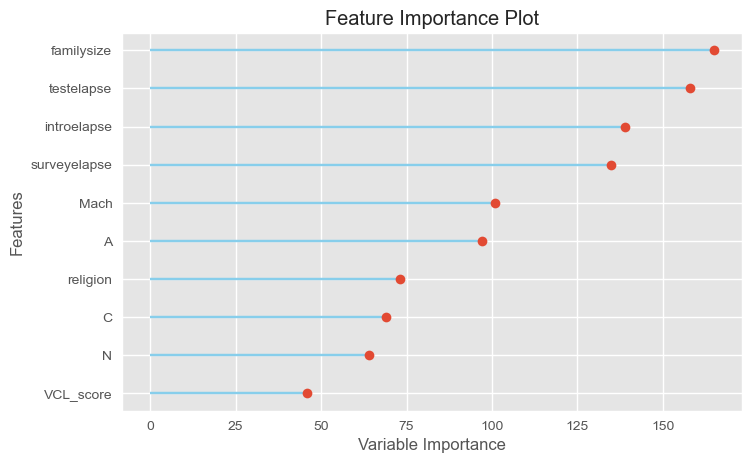

In [167]:
plot_model(model_lgbm, plot='feature')

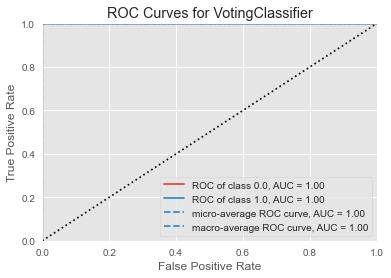

In [161]:
plot_model(blender_top5, plot='auc')

## Prediction for Test data 

In [74]:
# for total models 
for model in total_models : 
    prediction = predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7920,0.8824,0.8297,0.8047,0.8170,0.5762,0.5766


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7940,0.8830,0.8410,0.8009,0.8205,0.5792,0.5801


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7850,0.8705,0.8273,0.7964,0.8116,0.5615,0.5620


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7817,0.8636,0.8177,0.7973,0.8074,0.5555,0.5557


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7980,0.8719,0.8225,0.8176,0.8201,0.5898,0.5898


In [75]:
# for tuned models 
for model in tuned_models : 
    prediction = predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7920,0.8824,0.8297,0.8047,0.8170,0.5762,0.5766


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7940,0.8830,0.8410,0.8009,0.8205,0.5792,0.5801


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8037,0.8902,0.8356,0.8176,0.8265,0.6005,0.6007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7817,0.8636,0.8177,0.7973,0.8074,0.5555,0.5557


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7543,0.8710,0.9559,0.7077,0.8133,0.4767,0.5248


In [76]:
# for blended model 
prediction = predict_model(blender_top5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8120,0.9011,0.8946,0.7951,0.8419,0.6120,0.6185


# 6. Submission

In [30]:
pred = predict_model(blender_top5, raw_score=True)
pred[['Label', 'Score_1.0']].head(20)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.3496,0,0.0000,0.0000,0.0000,0.0000,0.0000


,Label,Score_1.0
0,0.0,0.2207
1,1.0,0.8820
2,1.0,0.9450
3,1.0,0.7293
4,1.0,0.9473
5,0.0,0.0572
6,1.0,0.7154
7,1.0,0.9236
8,1.0,0.5850
9,1.0,0.5421


In [31]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv(path + 'sample_submission.csv')
submission.head()

,index,nerdiness
0,0,-1
1,1,-1
2,2,-1
3,3,-1
4,4,-1


In [32]:
# 위에서 구한 예측값을 그대로 넣어줍니다.
submission['nerdiness'] = pred['Score_1.0']

# 데이터가 잘 들어갔는지 확인합니다.
submission

,index,nerdiness
0,0,0.2207
1,1,0.8820
2,2,0.9450
3,3,0.7293
4,4,0.9473
...,...,...
35447,35447,0.9575
35448,35448,0.8301
35449,35449,0.9824
35450,35450,0.2651


In [33]:
import datetime
filename = datetime.datetime.now().strftime("%m%d_%H_%M_%S")
filename

'0819_23_43_29'

In [34]:
submission.to_csv(path+"{}.csv".format(filename), index=False)

# 7. Saving Models

In [155]:
final_model = blender_top5 # you should fill out this 

In [40]:
# makes overfitting!! 
final_model = finalize_model(blender_top5) # you should fill out this 

In [156]:
import datetime
filename = datetime.datetime.now().strftime("%m%d_%H_%M")
filename = 'AUC90_alltrain_'+filename
filename

'AUC90_alltrain_0812_21_30'

In [157]:
save_model(final_model,path+filename)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['urban',
                                                             'education',
                                                             'gender', 'engnat',
                                                             'hand', 'religion',
                                                             'orientation',
                                                             'voted', 'married',
                                                             'ASD', 'Q1', 'Q2',
                                                             'Q3', 'Q4', 'Q5',
                                                             'Q6', 'Q7', 'Q8',
                                                             'Q9', 'Q10', 'Q11',
                                                             'Q12', 'Q13', 'Q14',
                                                             'Q15', 'Q16', 'Q17',
   